In [1]:
import pandas as pd
import numpy as np
df1=pd.read_excel('//content//drive//MyDrive//energy.xlsx')


In [2]:
numeric_columns = ['ForecastWindProduction', 'SystemLoadEA', 'SMPEA',
                   'ORKTemperature', 'ORKWindspeed', 'CO2Intensity',
                   'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']

# Replace commas (if any) and convert to numeric
for col in numeric_columns:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

# Verify the conversions
print(df1.dtypes)

# Ensure no NaN values are present after conversion
if df1.isnull().sum().sum() > 0:
    print("Warning: Missing values introduced after type conversion.")
else:
    print("All columns successfully converted to numeric.")

DateTime                  datetime64[ns]
HolidayFlag                        int64
DayOfWeek                          int64
WeekOfYear                         int64
Day                                int64
Month                              int64
Year                               int64
PeriodOfDay                        int64
ForecastWindProduction           float64
SystemLoadEA                     float64
SMPEA                            float64
ORKTemperature                   float64
ORKWindspeed                     float64
CO2Intensity                     float64
ActualWindProduction             float64
SystemLoadEP2                    float64
SMPEP2                           float64
dtype: object


In [3]:
# Convert the 'DateTime' column to pandas datetime format if not already
df1['DateTime'] = pd.to_datetime(df1['DateTime'], errors='coerce')

# Extract useful components from the 'DateTime' column (e.g., year, month, day, etc.)
df1['Year'] = df1['DateTime'].dt.year
df1['Month'] = df1['DateTime'].dt.month
df1['Day'] = df1['DateTime'].dt.day
df1['DayOfWeek'] = df1['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df1['Hour'] = df1['DateTime'].dt.hour

# Drop the original 'DateTime' column if it's no longer needed
df1 = df1.drop(columns=['DateTime'])

# Verify the transformation
print(df1.head())


   HolidayFlag  DayOfWeek  WeekOfYear  Day  Month  Year  PeriodOfDay  \
0            0          0          44    1     11  2021            0   
1            0          0          44    1     11  2021            1   
2            0          0          44    1     11  2021            2   
3            0          0          44    1     11  2021            3   
4            0          0          44    1     11  2021            4   

   ForecastWindProduction  SystemLoadEA  SMPEA  ORKTemperature  ORKWindspeed  \
0                  315.31       3388.77  49.26             6.0           9.3   
1                  321.80       3196.66  49.26             6.0          11.1   
2                  328.57       3060.71  49.10             5.0          11.1   
3                  335.60       2945.56  48.04             6.0           9.3   
4                  342.90       2849.34  33.75             6.0          11.1   

   CO2Intensity  ActualWindProduction  SystemLoadEP2  SMPEP2  Hour  
0        600.71  

In [4]:
# Drop rows with missing values
df1 = df1.dropna()

# Check if all missing values are eliminated
print("Number of missing values after dropping rows:", df1.isnull().sum().sum())


Number of missing values after dropping rows: 0


In [5]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X= df1.drop('SystemLoadEA', axis=1)
y = df1['SystemLoadEA']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [6]:
from sklearn import svm
svm=svm.SVR()
svm.fit(X_train,y_train)
y_svm=svm.predict(X_test)

mse = mean_squared_error(y_test, y_svm)
r2 = r2_score(y_test, y_svm)
rmse = np.sqrt(mse)

print("SVM")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

SVM
Mean Squared Error (MSE): 32729.23
Root Mean Squared Error (RMSE): 180.91
R-squared (R²): 0.96


In [7]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
y_rf=rf.predict(X_test)

mse = mean_squared_error(y_test, y_rf)
r2 = r2_score(y_test, y_rf)
rmse = np.sqrt(mse)

print("Random Forest Regressor")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Random Forest Regressor
Mean Squared Error (MSE): 11679.83
Root Mean Squared Error (RMSE): 108.07
R-squared (R²): 0.98


In [8]:
pip install lime

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


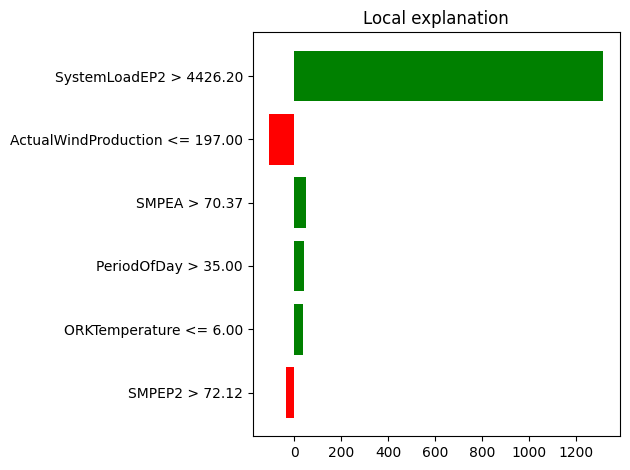

In [9]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
exp=LimeTabularExplainer(X_train.values,feature_names=X_train.columns.values.tolist(),class_names=["TYPE"],mode="regression")
e=exp.explain_instance(X_train.values[15],rf.predict,num_features=6)
e.as_pyplot_figure()
from matplotlib import pyplot as plt
plt.tight_layout()

In [10]:
e.show_in_notebook(show_table=True)

In [11]:
!pip install shap==0.44.0
!pip install shapash==2.4.1

In [12]:
!pip install scikit-learn==1.2.2 shap==0.44.0 shapash==2.4.1

In [13]:
import shapash
a=pd.DataFrame({"features":X_train.columns,"importance":rf.feature_importances_})
a.sort_values(by="importance",ascending=False,ignore_index=True)

features  importance
0            SystemLoadEP2    0.949542
1     ActualWindProduction    0.017849
2   ForecastWindProduction    0.007933
3                    SMPEA    0.003818
4              PeriodOfDay    0.003500
5               WeekOfYear    0.002829
6             CO2Intensity    0.002566
7           ORKTemperature    0.002211
8                      Day    0.002204
9                   SMPEP2    0.002054
10                    Hour    0.001311
11               DayOfWeek    0.001232
12            ORKWindspeed    0.001148
13                   Month    0.001052
14                    Year    0.000518
15             HolidayFlag    0.000232

In [14]:
from shapash.explainer.smart_explainer import SmartExplainer
xpl=SmartExplainer(rf)
xpl.compile(x=X_train[0:100])
xpl.plot.features_importance()

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7a724bc0f4c0>


In [16]:
xpl.plot.contribution_plot("SystemLoadEP2")

In [17]:
xpl.plot.contribution_plot("ActualWindProduction")

In [18]:
xpl.plot.contribution_plot("PeriodOfDay")